Step 1: Data Cleaning

Step 2: Feature Engineering
Available columns: ['Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level', 'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Roadwork and Construction Activity', 'Average Distance per Trip (km)', 'latitude', 'longitude', 'Date_2022-01-02', 'Date_2022-01-03', 'Date_2022-01-04', 'Date_2022-01-05', 'Date_2022-01-06', 'Date_2022-01-07', 'Date_2022-01-08', 'Date_2022-01-09', 'Date_2022-01-10', 'Date_2022-01-11', 'Date_2022-01-12', 'Date_2022-01-13', 'Date_2022-01-14', 'Date_2022-01-15', 'Date_2022-01-16', 'Date_2022-01-17', 'Date_2022-01-18', 'Date_2022-01-19', 'Date_2022-01-20', 'Date_2022-01-21', 'Date_2022-01-22', 'Date_2022-01-23', 'Date_2022-01-24', 'Date_2022-01-25', 'Date_2022-01-26', 'Date_2022-01-27', 'Date_2022-01-28', 'Date_2022-01-29', 'Date_2022-01-30', 'Date_2022-01-31', 'Date_202

100%|██████████| 2306/2306 [01:05<00:00, 35.21it/s]


Created graph with 2306 nodes and 1374126 edges

Step 4: Defining GNN Model

Step 5: Preparing Training Setup
Data split: 1615 train, 230 validation, 461 test nodes

Model initialized: TrafficGNN(
  (convs): ModuleList(
    (0): GCNConv(12, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 1)
  )
)
Input features: 12
Feature names: ['Traffic Volume', 'Average Speed', 'Travel Time Index', 'Congestion Level', 'Road Capacity Utilization', 'Incident Reports', 'Environmental Impact', 'Public Transport Usage', 'Traffic Signal Compliance', 'Parking Usage', 'Pedestrian and Cyclist Count', 'Average Distance per Trip (km)']
Using device: cpu

Step 6: Training and Evaluation
Starting training...
Epoch 020, Train Loss: 0.5988, Val Loss: 0.7067
Epoch 040, Train Loss: 0.5969, Val Loss: 0.6993
Epoch 060, Train Loss: 0.5965, Val Loss: 0.7001
Epoch 080, Train Loss: 0.5965, Val Loss: 0.6997
Epoch 100, Train Loss: 0.5967, Val Loss: 0.7000
Epoch 120, Train Loss: 0.5966, Val Loss: 0.6997
Epoch 140, Train L

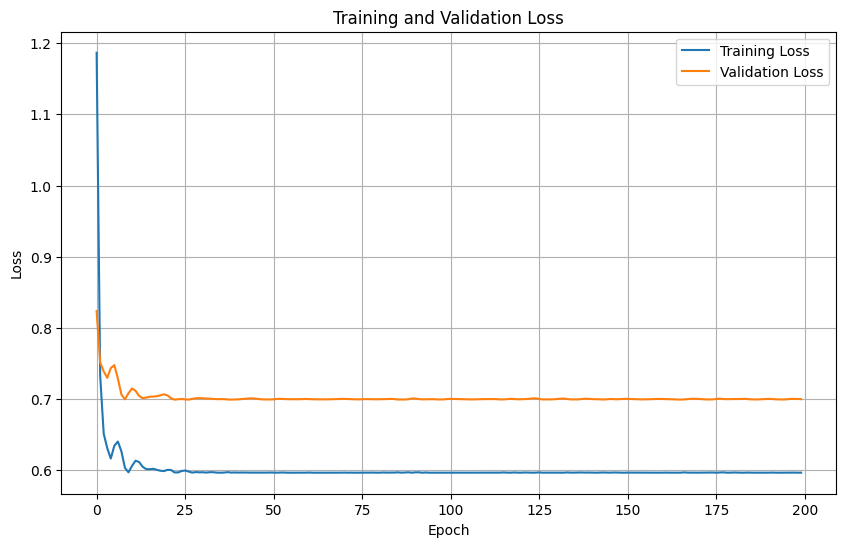

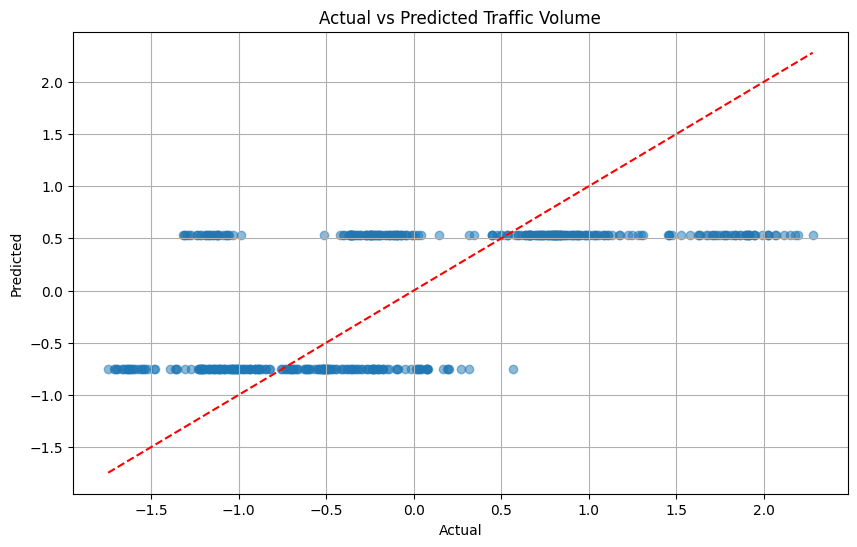


Step 7: Visualization and Analysis


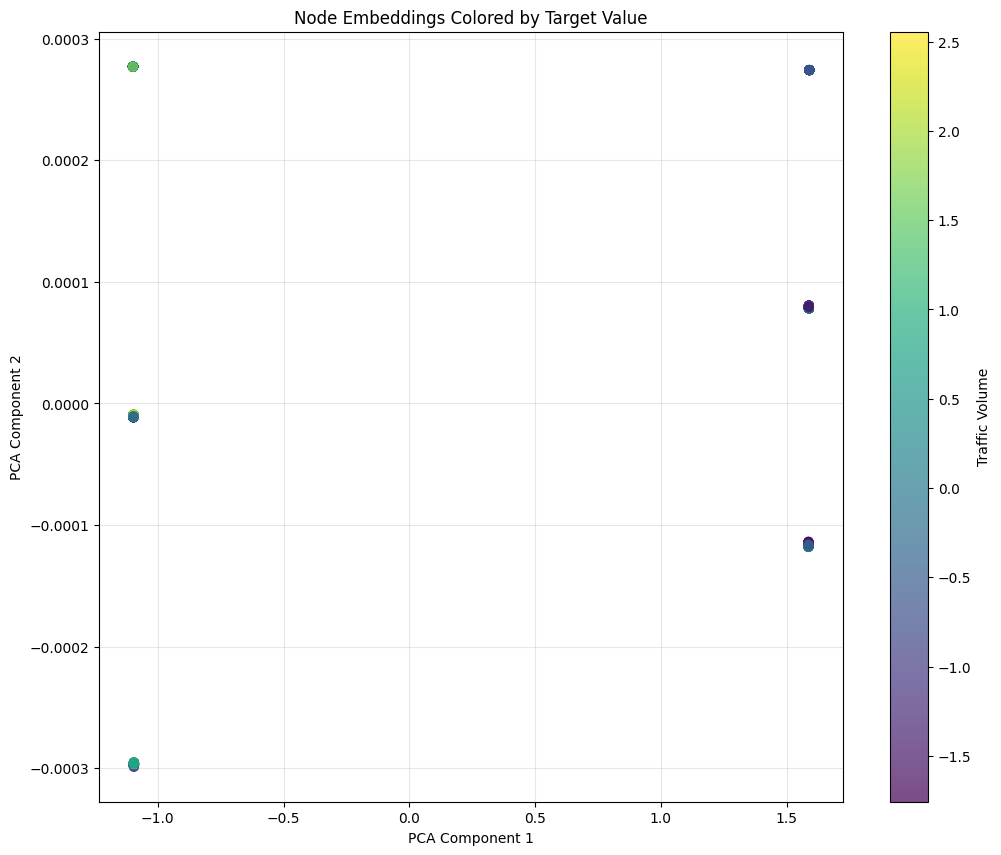


Feature Importance Analysis:

Top 10 Most Important Features:
1. Environmental Impact: 0.1257
2. Travel Time Index: 0.1156
3. Average Distance per Trip (km): 0.1134
4. Traffic Volume: 0.1093
5. Congestion Level: 0.1010
6. Road Capacity Utilization: 0.0993
7. Average Speed: 0.0871
8. Pedestrian and Cyclist Count: 0.0824
9. Incident Reports: 0.0758
10. Parking Usage: 0.0065


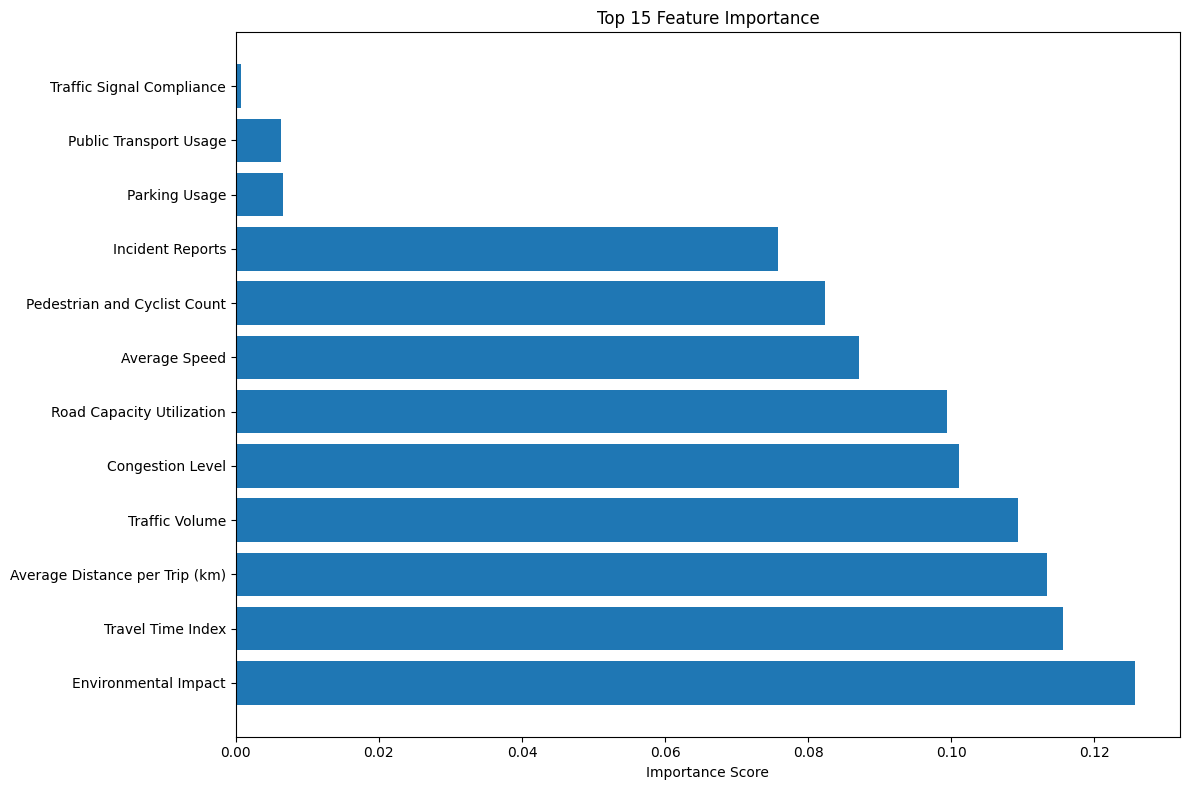

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import re
import h3
from tqdm import tqdm

# Step 1: Load and clean the data
# ------------------------------
# Assuming df is already loaded
# df = pd.read_csv('your_traffic_data.csv')

print("Step 1: Data Cleaning")
print("=====================")

# Function to clean formatted strings (currency, percentages, numbers with commas)
def clean_numeric_string(value):
    if not isinstance(value, str):
        return value

    # Remove currency symbols, commas, and convert percentages
    value = str(value)
    value = value.replace('₹', '').replace(',', '')

    # Convert percentages to decimal
    if '%' in value:
        value = value.replace('%', '')
        try:
            return float(value) / 100
        except:
            return np.nan

    # Convert to float
    try:
        return float(value)
    except:
        return np.nan

# Clean all object columns that should be numeric
object_cols = df.select_dtypes(include=['object']).columns
numeric_pattern = re.compile(r'.*(%|₹|,).*')

for col in object_cols:
    # Check if column contains formatted numbers
    sample_vals = df[col].dropna().iloc[:5].astype(str)
    if any(numeric_pattern.match(val) for val in sample_vals) or any(val.replace(',', '').replace('.', '').isdigit() for val in sample_vals):
        print(f"Cleaning numeric column: {col}")
        df[col] = df[col].apply(clean_numeric_string)
        # Convert to numeric type
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2: Feature engineering
# --------------------------
print("\nStep 2: Feature Engineering")
print("==========================")

# Convert date to datetime and extract useful features
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
    print("Added date-based features: DayOfWeek, Month, IsWeekend")

# First, print the actual columns to see what's available
print("Available columns:", df.columns.tolist())

# Then modify your categorical_cols to match what's actually in the DataFrame
# For example:
categorical_cols = [col for col in ['Area Name', 'Road/Intersection Name', 'Weather Conditions',
                    'Roadwork and Construction Activity', 'Ward'] if col in df.columns]

print(f"Using these categorical columns for encoding: {categorical_cols}")

# If no matching columns were found, provide a warning
if not categorical_cols:
    print("Warning: None of the specified categorical columns exist in the DataFrame.")
    # Either continue without encoding or use other columns
    # df_encoded = df.copy()  # Option to continue without encoding
else:
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    print(f"One-hot encoded {len(categorical_cols)} categorical columns")

# Step 3: Create meaningful edges based on geographic proximity and time
# -------------------------------------------------------------------
print("\nStep 3: Creating Graph Structure")
print("==============================")

def create_graph_from_dataframe(df, geographic_radius=0.01, temporal_window=1):
    """
    Create a graph where nodes are connected if they are:
    1. Geographically close (within radius in lat/long)
    2. Sequential in time (within temporal_window days)
    3. In the same area
    """
    # Get numeric features for nodes
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    # Exclude lat/long as they'll be used for edge creation
    feature_cols = [col for col in numeric_cols if col not in ['latitude', 'longitude']]

    # Normalize features
    X = df[feature_cols].values
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_normalized, dtype=torch.float)

    # Create edge index based on geographic proximity and time
    edge_index = []
    num_nodes = len(df)

    print(f"Creating edges for {num_nodes} nodes...")

    # Sort by date if available
    if 'Date' in df.columns:
        df_sorted = df.sort_values('Date').reset_index()
        sorted_indices = df_sorted['index'].values
        date_dict = {idx: date for idx, date in zip(df_sorted.index, df_sorted['Date'])}
    else:
        sorted_indices = df.index.values
        date_dict = None

    # For each node, connect to nearby nodes
    for i in tqdm(range(num_nodes)):
        node_i = df.iloc[i]

        # 1. Connect sequentially close nodes
        if i > 0:
            edge_index.append([i, i-1])
        if i < num_nodes-1:
            edge_index.append([i, i+1])

        # 2. Connect geographically close nodes
        if 'latitude' in df.columns and 'longitude' in df.columns:
            lat_i, lon_i = node_i['latitude'], node_i['longitude']

            # For efficiency, only check nodes within a reasonable range
            nearby_nodes = df[
                (df.index != i) &
                (abs(df['latitude'] - lat_i) < geographic_radius) &
                (abs(df['longitude'] - lon_i) < geographic_radius)
            ]

            for j in nearby_nodes.index:
                # Calculate exact distance
                lat_j, lon_j = df.loc[j, 'latitude'], df.loc[j, 'longitude']
                dist = np.sqrt((lat_i - lat_j)**2 + (lon_i - lon_j)**2)

                if dist < geographic_radius:
                    edge_index.append([i, j])

        # 3. Connect nodes in the same area
        if 'Area Name' in df.columns:
            area_i = node_i['Area Name']
            same_area_nodes = df[(df.index != i) & (df['Area Name'] == area_i)].index
            for j in same_area_nodes[:5]:  # Limit to 5 connections per area
                edge_index.append([i, j])

        # 4. Connect H3 neighbors if h3_index is available
        if 'h3_index' in df.columns and isinstance(node_i['h3_index'], str):
            try:
                h3_neighbors = h3.k_ring(node_i['h3_index'], 1)
                neighbor_indices = df[df['h3_index'].isin(h3_neighbors) & (df.index != i)].index
                for j in neighbor_indices:
                    edge_index.append([i, j])
            except:
                pass  # Skip if h3 index is invalid

    # Convert to tensor and make undirected
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_index = to_undirected(edge_index)

    # Remove duplicate edges
    edge_index = torch.unique(edge_index, dim=1)

    print(f"Created graph with {X_tensor.shape[0]} nodes and {edge_index.shape[1]//2} edges")

    # Prepare target variable (Traffic Volume for example)
    target_col = 'Traffic Volume'  # Change to your desired target
    if target_col in df.columns:
        y = df[target_col].values
        # Normalize target
        y = (y - y.mean()) / y.std()
        y_tensor = torch.tensor(y, dtype=torch.float).view(-1, 1)

        # Create PyG data object
        data = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

        # List of feature names for later reference
        data.feature_names = feature_cols
        data.target_name = target_col

        return data, scaler
    else:
        print(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")
        return None, None

# Create the graph
data, scaler = create_graph_from_dataframe(df_encoded)

# Step 4: Define the GNN model
# --------------------------
print("\nStep 4: Defining GNN Model")
print("=========================")

class TrafficGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels=64, out_channels=1, num_layers=3, dropout=0.2):
        super(TrafficGNN, self).__init__()

        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))

        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))

        # Output layer
        self.convs.append(GCNConv(hidden_channels, out_channels))

        self.dropout = dropout

    def forward(self, x, edge_index):
        # Input layer
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Output layer
        x = self.convs[-1](x, edge_index)
        return x

# Step 5: Prepare for training
# --------------------------
print("\nStep 5: Preparing Training Setup")
print("==============================")

def prepare_training(data, test_ratio=0.2, val_ratio=0.1):
    # Split nodes into train/val/test
    num_nodes = data.x.size(0)
    indices = torch.randperm(num_nodes)

    test_size = int(num_nodes * test_ratio)
    val_size = int(num_nodes * val_ratio)
    train_size = num_nodes - test_size - val_size

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    # Create masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_indices] = True
    val_mask[val_indices] = True
    test_mask[test_indices] = True

    # Add masks to data
    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    print(f"Data split: {train_mask.sum().item()} train, {val_mask.sum().item()} validation, {test_mask.sum().item()} test nodes")

    return data

# If data is available, prepare it for training
if data is not None:
    data = prepare_training(data)

    # Initialize model
    in_channels = data.x.size(1)
    model = TrafficGNN(in_channels=in_channels, hidden_channels=64, out_channels=1)

    print(f"\nModel initialized: {model}")
    print(f"Input features: {in_channels}")
    if hasattr(data, 'feature_names'):
        print(f"Feature names: {data.feature_names}")

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    data = data.to(device)

    print(f"Using device: {device}")

# Step 6: Training and evaluation
# -----------------------------
print("\nStep 6: Training and Evaluation")
print("=============================")

def train_and_evaluate(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data.x, data.edge_index)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_losses.append(val_loss.item())

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()

        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

    # Load best model for evaluation
    model.load_state_dict(best_model_state)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_loss = criterion(out[data.test_mask], data.y[data.test_mask])

        # Convert to numpy for metric calculation
        y_true = data.y[data.test_mask].cpu().numpy()
        y_pred = out[data.test_mask].cpu().numpy()

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        print("\nTest Results:")
        print(f"MSE: {test_loss:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")

    # Plot training curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_curve.png')
    plt.show()

    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs Predicted {data.target_name}')
    plt.grid(True)
    plt.savefig('predictions.png')
    plt.show()

    return model, r2, mae, rmse

# Run training if data is available
if data is not None:
    print("Starting training...")
    trained_model, r2, mae, rmse = train_and_evaluate(model, data, epochs=200)

    # Step 7: Visualize and analyze results
    # -----------------------------------
    print("\nStep 7: Visualization and Analysis")
    print("================================")

    # Node embedding visualization
    def visualize_embeddings(model, data):
        model.eval()
        with torch.no_grad():
            # Get embeddings from second-to-last layer
            embeddings = model.convs[0](data.x, data.edge_index)
            for i in range(1, len(model.convs) - 1):
                embeddings = model.convs[i](F.relu(embeddings), data.edge_index)

            # Reduce to 2D for visualization
            from sklearn.decomposition import PCA
            embeddings_np = embeddings.cpu().numpy()
            pca = PCA(n_components=2)
            reduced_embeddings = pca.fit_transform(embeddings_np)

            # Create visualization
            plt.figure(figsize=(12, 10))

            # Color by target value
            y_values = data.y.cpu().numpy().flatten()
            sc = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1],
                      c=y_values, cmap='viridis', alpha=0.7, s=40)
            plt.colorbar(sc, label=data.target_name)

            plt.title('Node Embeddings Colored by Target Value')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.grid(True, alpha=0.3)
            plt.savefig('node_embeddings.png')
            plt.show()

    # Visualize embeddings
    visualize_embeddings(trained_model, data)

    # Feature importance analysis
    print("\nFeature Importance Analysis:")
    if hasattr(data, 'feature_names'):
        # Simple approach - use first layer weights
        weights = model.convs[0].lin.weight.cpu().detach().numpy()
        importance = np.abs(weights).mean(axis=0)
        feature_importance = dict(zip(data.feature_names, importance))

        # Sort by importance
        sorted_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

        # Print top 10 features
        print("\nTop 10 Most Important Features:")
        for i, (feature, score) in enumerate(list(sorted_importance.items())[:10]):
            print(f"{i+1}. {feature}: {score:.4f}")

        # Plot feature importance
        plt.figure(figsize=(12, 8))
        features = list(sorted_importance.keys())[:15]
        scores = list(sorted_importance.values())[:15]

        plt.barh(features, scores)
        plt.xlabel('Importance Score')
        plt.title('Top 15 Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
else:
    print("Unable to create graph data. Please check your dataset and target variable.")

In [11]:
pip install h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 24.7 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.1 MB/s eta 0:00:00
